In [1]:
import requests
import json

import pymongo
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
import re
import torch
import os
from scipy.signal import stft
import random
import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import time
import torch.utils.data
from torch.nn.utils.rnn import pad_sequence

In [2]:
print(torch.__version__)


1.4.0+cu100


In [3]:
cou = 655058

In [4]:
EOS_voc = cou + 1
vocab_word_size = cou + 2
max_length = 150
teacher_forcing_p = 0.8
max_words_c = 30
max_word_l = 16

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
print(device)

cuda


In [7]:
print("A")

A


In [8]:
n_epochs = 10
vec_size = 512
vocab_ngram_size = 35
starting_lr = 1e-3

In [9]:
class CharGRU(nn.Module):
    def __init__(self, hidden_size, char_vocab_size):
        super(CharGRU, self).__init__()
        self.gru = nn.GRU(char_vocab_size, hidden_size, batch_first=True)
        self.mask = torch.ones((1, 1, 35))
        self.mask[0][0][0] = 0
        self.mask = self.mask.to(device)

    def forward(self, X):
        x_o = F.one_hot(X, num_classes=35)
        x_o = self.mask * x_o
        _, finstate = self.gru(x_o)
        del _
        return finstate

In [10]:
class NRNN(nn.Module):
    def __init__(self, hidden_size, char_vocab_size, output_size, n_layers=1, dropout_p=0):
        super(NRNN, self).__init__()
        self.hidden_size = hidden_size
        self.chargru = CharGRU(hidden_size, char_vocab_size)
        self.lstm = nn.GRU(hidden_size, hidden_size, num_layers=n_layers, batch_first=True, dropout=dropout_p, bidirectional=True)
        #self.out = nn.Linear(hidden_size * 2, output_size)
        self.out = nn.AdaptiveLogSoftmaxWithLoss(hidden_size * 2, output_size, cutoffs=[3000, 20000, 100000], div_value=4.0)
    def forward(self, x, targets, mask):
        X = x.view((x.shape[0] * x.shape[1], x.shape[2]))
        X = self.chargru(X)
        X = X.view(x.shape[:2] + (-1,))
        lstm_outputs, _ = self.lstm(X)
        lstm_outputs = lstm_outputs.reshape(lstm_outputs.shape[0] * lstm_outputs.shape[1], lstm_outputs.shape[2])
        out, _ = self.out(lstm_outputs, targets)
        #lstm_outputs = self.out(lstm_outputs)
        #lstm_outputs = torch.view(x.shape[:2] + (-1,))
        return -torch.sum(out * mask)
    def predict(self, x):
        X = x.view((x.shape[0] * x.shape[1], x.shape[2]))
        X = self.chargru(X)
        X = X.view(x.shape[:2] + (-1,))
        lstm_outputs, _ = self.lstm(X)
        lstm_outputs = lstm_outputs.reshape(lstm_outputs.shape[0] * lstm_outputs.shape[1], lstm_outputs.shape[2])
        out = self.out.predict(lstm_outputs)
        return out

In [11]:
rev_dict = torch.load("source_files/rev_dict")

In [12]:
rev_dict[EOS_voc]

1

In [13]:
fileind = 12

In [14]:
vec_size

512

In [15]:
now_lr = starting_lr / 2

In [16]:
#model = NRNN(vec_size // 2, 35, vocab_word_size)
model = torch.load("512ASmodel1layergru_epoch_3.pt")
#model = torch.load("Opposition_512ASmodel1layergru_epoch_8.pt")

In [17]:
file_output_b = open("v2_512AS_model_training_GRU1LAYER_output_batch", "wt", buffering=1)
file_output_e = open("v2_512AS_model_training_GRU1LAYER_output_epoch", "wt", buffering=1)


In [18]:
file_output_b_n = open("v2_512AS_model_eval_GRU1LAYER_output_batch", "wt", buffering=1)


In [19]:
#file_dataset_separators = open("dataset_separators", "wt", buffering=1)

In [ ]:
import datetime
print(datetime.datetime.now())

new_batch_size = 256
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
test_losses_data = []
train_losses_data = []
for epoch in range(3, 6):
    opt = optim.Adam(model.parameters(), lr=now_lr)
    train_losses = []
    test_losses = []
    last_train_loss = 0
    last_test_loss = 0
    batch_n = 0
    for file_idx in range(fileind):
        my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
        for is_test, x1, y1 in my_data_from_file:
            for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
                x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
                mask = (target != 0)
                batch_n += 1
                tt = time.time()
                opt.zero_grad()
                x_inp = pad_sequence(x, batch_first=True).long().to(device)
                target_inp = target.view(-1).to(device)
                maskinp = mask.view(-1).to(device)
                loss = model(x_inp, target_inp, maskinp)
                if (is_test == 0):
                    loss.backward()
                    opt.step()
                    del x_inp
                    del target_inp
                    train_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    train_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                else:
                    del x_inp
                    del target_inp
                    test_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    test_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                modt += time.time() - tt
                if (batch_n % (100 * 2048 // new_batch_size) == 0):
                    print('Batch [{}]\t Test loss: {}, Train loss: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(test_losses[-(100 * 2048 // new_batch_size):]).mean(), np.array(train_losses[-(100 * 2048 // new_batch_size):]).mean(), time.time() - tbegin, modt), file=file_output_b)
        del my_data_from_file
    now_lr /= 2
    torch.save(model, f"512ASmodel1layergru_epoch_{epoch + 1}.pt")
    print('epoch [{} / {}]\t Test loss: {}, Train loss: {}, Time: {}'.format(epoch, n_epochs, np.array(test_losses).mean(), np.array(train_losses).mean(), time.time() - tbegin), file=file_output_e)

2020-06-01 13:04:50.382324


/home/user1/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user1/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharGRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [21]:
file_output_b_n = open("v2_512AS_model_eval_GRU1LAYER_output_batch", "wt", buffering=1)


In [35]:
del model
model = torch.load("512ASmodel1layergru_epoch_4.pt")
file_output_b_n = open("v2.1_512AS_model_eval_GRU1LAYER_output_batch", "wt", buffering=1)


In [36]:
mistakes_dict = [0] * (vocab_word_size + 3)
#loss_f = nn.CrossEntropyLoss(reduction='none').to(device)
import datetime
print(datetime.datetime.now())

new_batch_size = 64
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
accuracy_b = []
last_train_loss = 0
last_test_loss = 0
batch_n = 0
cou_total = 0
cou_mistakes = 0
cou_first_word_mistakes = 0
correct_sents = 0
total_sents = 0
for file_idx in range(fileind):
    local_batch_n = 0
    my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
    for is_test, x1, y1 in my_data_from_file:
        if (is_test == 0):
            continue
        for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
            x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
            mask = (target != 0)
            batch_n += 1
            tt = time.time()
            x_inp = pad_sequence(x, batch_first=True).long().to(device)
            target_inp = target.view(-1).to(device)
            maskinp = mask.view(-1).to(device)
            out = model.predict(x_inp)
            for i in target * (target != out.cpu().reshape(target.shape)) * mask:
                for j in i:
                    mistakes_dict[j.data.item()] += 1
            correct_sents += torch.sum(torch.sum(((target_inp == out).double() * maskinp).reshape(target.shape), dim=1) == torch.sum((maskinp).reshape(target.shape), dim=1))
            total_sents += len(y)
            cou_mistakes += torch.sum((target_inp == out).double() * maskinp)
            cou_total += torch.sum(maskinp)
            accuracy = torch.sum((target_inp == out).double() * maskinp) / torch.sum(maskinp)
            cou_first_word_mistakes += torch.sum((out.reshape(target.shape)[:, 0] != target_inp.reshape(target.shape)[:, 0]).double())
            accuracy_b.append(accuracy.data.item())
            del x_inp
            del target_inp
            del maskinp
            modt += time.time() - tt
            if (batch_n % (100 * 2048 // new_batch_size) == 0):
                print('Batch: [{}]\t Accuracy: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(accuracy_b[-(100 * 2048 // new_batch_size)]).mean(), time.time() - tbegin, modt), file=file_output_b_n)
    del my_data_from_file


2020-06-02 13:10:53.988670


In [37]:
np.array(accuracy_b).mean()

0.9012287135953333

In [38]:
correct_sents.double() / total_sents

tensor(0.4741, device='cuda:0', dtype=torch.float64)

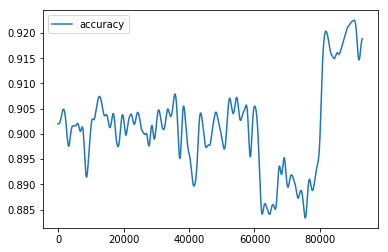

In [44]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b), sigma=500), columns=['accuracy']).plot(y='accuracy', kind='line')

In [23]:
np.array(accuracy_b).mean()

0.9037553702669991

In [24]:
correct_sents.double() / total_sents

tensor(0.4819, device='cuda:0', dtype=torch.float64)

In [25]:
import pandas as pd 

In [26]:
from scipy.ndimage.filters import gaussian_filter1d


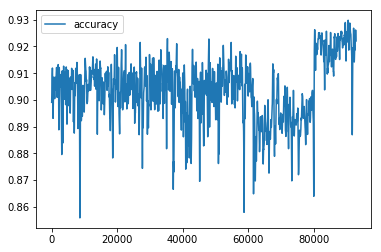

In [27]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b), sigma=50), columns=['accuracy']).plot(y='accuracy', kind='line')

In [30]:
sum(mistakes_dict[1:3000]) / sum(mistakes_dict[1:])

0.16412699012562965

In [31]:
sum(mistakes_dict[3000:20000]) / sum(mistakes_dict[1:])

0.13005296975371533

In [32]:
sum(mistakes_dict[20000:100000]) / sum(mistakes_dict[1:])

0.25527730838376694

In [33]:
sum(mistakes_dict[100000:]) / sum(mistakes_dict[1:])

0.4505427317368881

In [34]:
mistakes_dict[100000:]

[29,
 32,
 26,
 28,
 36,
 22,
 28,
 28,
 16,
 29,
 23,
 19,
 21,
 0,
 36,
 23,
 36,
 42,
 14,
 17,
 14,
 30,
 26,
 33,
 17,
 26,
 12,
 25,
 34,
 28,
 18,
 44,
 24,
 22,
 34,
 34,
 23,
 20,
 30,
 26,
 26,
 27,
 32,
 17,
 19,
 24,
 29,
 15,
 22,
 14,
 27,
 17,
 35,
 28,
 22,
 28,
 16,
 35,
 35,
 25,
 25,
 16,
 24,
 27,
 25,
 27,
 26,
 27,
 31,
 22,
 3,
 16,
 25,
 19,
 29,
 26,
 10,
 35,
 24,
 23,
 23,
 1,
 18,
 17,
 15,
 27,
 25,
 14,
 35,
 35,
 24,
 25,
 27,
 14,
 6,
 13,
 17,
 22,
 27,
 23,
 23,
 3,
 30,
 32,
 29,
 27,
 29,
 25,
 27,
 26,
 28,
 23,
 15,
 37,
 35,
 20,
 23,
 21,
 32,
 18,
 25,
 39,
 12,
 30,
 28,
 26,
 33,
 19,
 28,
 29,
 31,
 34,
 27,
 22,
 28,
 26,
 22,
 22,
 25,
 22,
 40,
 25,
 20,
 16,
 19,
 22,
 22,
 35,
 0,
 22,
 34,
 24,
 25,
 4,
 29,
 32,
 22,
 37,
 22,
 18,
 32,
 16,
 35,
 28,
 36,
 25,
 29,
 20,
 3,
 27,
 26,
 19,
 28,
 31,
 27,
 1,
 42,
 27,
 23,
 19,
 26,
 33,
 18,
 25,
 35,
 17,
 0,
 31,
 42,
 22,
 22,
 35,
 29,
 17,
 30,
 43,
 23,
 11,
 26,
 29,
 34,
 17,


In [65]:
!pip install AdaBound

Looking in indexes: https://pypi.org/simple, https://pypi.apsolutions.ru/simple
You should consider upgrading via the '/home/user1/.pyenv/versions/3.6.6/bin/python3 -m pip install --upgrade pip' command.


In [186]:
import torch.nn.utils as utils

In [208]:
import adabound

In [234]:
del model
model = torch.load("Oppositionv4_512ASmodel1layergru_epoch_10.pt")
now_lr = 1e-3
opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=2e-3)
lrlambda = lambda epoch: 0.8
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda=lrlambda)

In [235]:
del my_data_from_file

NameError: name 'my_data_from_file' is not defined

In [236]:
file_output_b = open("Oppositionv7_512AS_model_training_GRU1LAYER_output_batch", "wt", buffering=1)
file_output_e = open("Oppositionv7_512AS_model_training_GRU1LAYER_output_epoch", "wt", buffering=1)


In [237]:
file_output_b_n = open("Oppositionv7_512AS_model_eval_GRU1LAYER_output_batch", "wt", buffering=1)

In [ ]:
import datetime
print(datetime.datetime.now())

new_batch_size = 256
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
test_losses_data = []
train_losses_data = []
for epoch in range(10, 20):
    train_losses = []
    test_losses = []
    last_train_loss = 0
    last_test_loss = 0
    batch_n = 0
    for file_idx in range(10, 12):
        local_batch_n = 0
        my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
        for is_test, x1, y1 in my_data_from_file:
            if (file_idx == 10 and local_batch_n <= 624):
                local_batch_n += 1
                continue
            local_batch_n += 1
            for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
                x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
                mask = (target != 0)
                batch_n += 1
                tt = time.time()
                opt.zero_grad()
                x_inp = pad_sequence(x, batch_first=True).long().to(device)
                target_inp = target.view(-1).to(device)
                maskinp = mask.view(-1).to(device)
                loss = model(x_inp, target_inp, maskinp)
                if (is_test == 0):
                    loss.backward()
                    opt.step()
                    del x_inp
                    del target_inp
                    train_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    train_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                else:
                    del x_inp
                    del target_inp
                    test_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    test_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                modt += time.time() - tt
                if (batch_n % (100 * 2048 // new_batch_size) == 0):
                    print('Batch [{}]\t Test loss: {}, Train loss: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(test_losses[-(100 * 2048 // new_batch_size):]).mean(), np.array(train_losses[-(100 * 2048 // new_batch_size):]).mean(), time.time() - tbegin, modt), file=file_output_b)
        del my_data_from_file
    if (epoch >= 10):
        sched.step()
    torch.save(model, f"Oppositionv7_512ASmodel1layergru_epoch_{epoch + 1}.pt")
    print('epoch [{} / {}]\t Test loss: {}, Train loss: {}, Time: {}'.format(epoch, n_epochs, np.array(test_losses).mean(), np.array(train_losses).mean(), time.time() - tbegin), file=file_output_e)

2020-06-07 15:31:03.217564


In [229]:
model = torch.load("Oppositionv6_512ASmodel1layergru_epoch_16.pt")


In [239]:
del my_data_from_file

NameError: name 'my_data_from_file' is not defined

In [240]:
mistakes_dict = [0] * (vocab_word_size + 3)
#loss_f = nn.CrossEntropyLoss(reduction='none').to(device)
import datetime
print(datetime.datetime.now())

new_batch_size = 64
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
accuracy_b = []
last_train_loss = 0
last_test_loss = 0
batch_n = 0
cou_total = 0
cou_mistakes = 0
cou_first_word_mistakes = 0
correct_sents = 0
total_sents = 0
for file_idx in range(10, 12):
    local_batch_n = 0
    my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
    for is_test, x1, y1 in my_data_from_file:
        if (file_idx == 10 and local_batch_n <= 624):
            local_batch_n += 1
            continue
        local_batch_n += 1
        if (is_test == 0):
            continue
        for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
            x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
            mask = (target != 0)
            batch_n += 1
            tt = time.time()
            x_inp = pad_sequence(x, batch_first=True).long().to(device)
            target_inp = target.view(-1).to(device)
            maskinp = mask.view(-1).to(device)
            out = model.predict(x_inp)
            for i in target * (target != out.cpu().reshape(target.shape)) * mask:
                for j in i:
                    mistakes_dict[j.data.item()] += 1
            correct_sents += torch.sum(torch.sum(((target_inp == out).double() * maskinp).reshape(target.shape), dim=1) == torch.sum((maskinp).reshape(target.shape), dim=1))
            total_sents += len(y)
            cou_mistakes += torch.sum((target_inp == out).double() * maskinp)
            cou_total += torch.sum(maskinp)
            accuracy = torch.sum((target_inp == out).double() * maskinp) / torch.sum(maskinp)
            cou_first_word_mistakes += torch.sum((out.reshape(target.shape)[:, 0] != target_inp.reshape(target.shape)[:, 0]).double())
            accuracy_b.append(accuracy.data.item())
            del x_inp
            del target_inp
            del maskinp
            modt += time.time() - tt
            if (batch_n % (100 * 2048 // new_batch_size) == 0):
                print('Batch: [{}]\t Accuracy: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(accuracy_b[-(100 * 2048 // new_batch_size):]).mean(), time.time() - tbegin, modt), file=file_output_b_n)
    del my_data_from_file


2020-06-08 00:33:12.574670


In [247]:
sum(accuracy_b[12800:]) / len(accuracy_b[12800:])

0.9466237731270029

In [250]:
sum(accuracy_b[3200:6400]) / len(accuracy_b[3200:6400])

0.9419721980810152

In [249]:
for i in range(4):
    print(sum(accuracy_b[3200 * i:3200 * i + 3200]) / len(accuracy_b[3200 * i:3200 * i + 3200]))

0.9448392881168993
0.9419721980810152
0.9460966326835034
0.9459092405029764


In [241]:
np.array(accuracy_b).mean()

0.9447112131086636

In [242]:
correct_sents.double() / total_sents

tensor(0.6230, device='cuda:0', dtype=torch.float64)

In [232]:
np.array(accuracy_b).mean()

0.9444281891279506

In [233]:
correct_sents.double() / total_sents

tensor(0.6217, device='cuda:0', dtype=torch.float64)

In [83]:
np.array(accuracy_b).mean()

0.9225361150219267

In [84]:
correct_sents.double() / total_sents

tensor(0.5227, device='cuda:0', dtype=torch.float64)

In [56]:
np.array(accuracy_b).mean()

0.9170018707595056

In [57]:
correct_sents.double() / total_sents

tensor(0.5008, device='cuda:0', dtype=torch.float64)

In [26]:
np.array(accuracy_b).mean()

0.916603915814975

In [27]:
correct_sents.double() / total_sents

tensor(0.4996, device='cuda:0', dtype=torch.float64)

In [28]:
next(model.parameters()).is_cuda

True

In [251]:
del model
model = torch.load("512ASmodel1layergru_epoch_4.pt")
now_lr = 1e-3
opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=2e-3)
lrlambda = lambda epoch: 0.8
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda=lrlambda)

In [252]:
file_output_b = open("Religionv1_512AS_model_training_GRU1LAYER_output_batch", "wt", buffering=1)
file_output_e = open("Religionv1_512AS_model_training_GRU1LAYER_output_epoch", "wt", buffering=1)


In [253]:
file_output_b_n = open("Religionv1_512AS_model_eval_GRU1LAYER_output_batch", "wt", buffering=1)


In [260]:
import datetime
print(datetime.datetime.now())

new_batch_size = 256
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
test_losses_data = []
train_losses_data = []
for epoch in range(11, 12):
    train_losses = []
    test_losses = []
    last_train_loss = 0
    last_test_loss = 0
    batch_n = 0
    for file_idx in range(0, 8):
        local_batch_n = 0
        my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
        for is_test, x1, y1 in my_data_from_file:
            if (file_idx == 7 and local_batch_n >= 2193):
                break
            local_batch_n += 1
            for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
                x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
                mask = (target != 0)
                batch_n += 1
                tt = time.time()
                opt.zero_grad()
                x_inp = pad_sequence(x, batch_first=True).long().to(device)
                target_inp = target.view(-1).to(device)
                maskinp = mask.view(-1).to(device)
                loss = model(x_inp, target_inp, maskinp)
                if (is_test == 0):
                    loss.backward()
                    opt.step()
                    del x_inp
                    del target_inp
                    train_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    train_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                else:
                    del x_inp
                    del target_inp
                    test_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    test_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                modt += time.time() - tt
                if (batch_n % (100 * 2048 // new_batch_size) == 0):
                    print('Batch [{}]\t Test loss: {}, Train loss: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(test_losses[-(100 * 2048 // new_batch_size):]).mean(), np.array(train_losses[-(100 * 2048 // new_batch_size):]).mean(), time.time() - tbegin, modt), file=file_output_b)
        del my_data_from_file
    if (epoch > 5):
        sched.step()
    torch.save(model, f"Religionv1_512ASmodel1layergru_epoch_{epoch + 1}.pt")
    print('epoch [{} / {}]\t Test loss: {}, Train loss: {}, Time: {}'.format(epoch, n_epochs, np.array(test_losses).mean(), np.array(train_losses).mean(), time.time() - tbegin), file=file_output_e)

2020-06-09 21:51:14.233885


In [ ]:
mistakes_dict = [0] * (vocab_word_size + 3)
#loss_f = nn.CrossEntropyLoss(reduction='none').to(device)
import datetime
print(datetime.datetime.now())

new_batch_size = 64
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
accuracy_b = []
last_train_loss = 0
last_test_loss = 0
batch_n = 0
cou_total = 0
cou_mistakes = 0
cou_first_word_mistakes = 0
correct_sents = 0
total_sents = 0
for file_idx in range(0, 8):
    local_batch_n = 0
    my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
    for is_test, x1, y1 in my_data_from_file:
        if (file_idx == 7 and local_batch_n >= 2193):
            break
        local_batch_n += 1
        if (is_test == 0):
            continue
        for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
            x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
            mask = (target != 0)
            batch_n += 1
            tt = time.time()
            x_inp = pad_sequence(x, batch_first=True).long().to(device)
            target_inp = target.view(-1).to(device)
            maskinp = mask.view(-1).to(device)
            out = model.predict(x_inp)
            for i in target * (target != out.cpu().reshape(target.shape)) * mask:
                for j in i:
                    mistakes_dict[j.data.item()] += 1
            correct_sents += torch.sum(torch.sum(((target_inp == out).double() * maskinp).reshape(target.shape), dim=1) == torch.sum((maskinp).reshape(target.shape), dim=1))
            total_sents += len(y)
            cou_mistakes += torch.sum((target_inp == out).double() * maskinp)
            cou_total += torch.sum(maskinp)
            accuracy = torch.sum((target_inp == out).double() * maskinp) / torch.sum(maskinp)
            cou_first_word_mistakes += torch.sum((out.reshape(target.shape)[:, 0] != target_inp.reshape(target.shape)[:, 0]).double())
            accuracy_b.append(accuracy.data.item())
            del x_inp
            del target_inp
            del maskinp
            modt += time.time() - tt
            if (batch_n % (100 * 2048 // new_batch_size) == 0):
                print('Batch: [{}]\t Accuracy: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(accuracy_b[-(100 * 2048 // new_batch_size)]).mean(), time.time() - tbegin, modt), file=file_output_b_n)
    del my_data_from_file


2020-06-10 01:59:12.913689


In [262]:
np.array(accuracy_b).mean()

0.9419921533799485

In [263]:
correct_sents.double() / total_sents

tensor(0.6323, device='cuda:0', dtype=torch.float64)

In [34]:
np.array(accuracy_b).mean()

0.9197503317460483

In [35]:
correct_sents.double() / total_sents

tensor(0.5394, device='cuda:0', dtype=torch.float64)

In [264]:
del model
model = torch.load("512ASmodel1layergru_epoch_4.pt")
now_lr = 1e-3
opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=2e-3)
lrlambda = lambda epoch: 0.8
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda=lrlambda)

In [265]:
file_output_b = open("Gardeningv1_512AS_model_training_GRU1LAYER_output_batch", "wt", buffering=1)
file_output_e = open("Gardeningv1_512AS_model_training_GRU1LAYER_output_epoch", "wt", buffering=1)


In [266]:
file_output_b_n = open("Gardeningv1_512AS_model_eval_GRU1LAYER_output_batch", "wt", buffering=1)


In [269]:
import datetime
print(datetime.datetime.now())

new_batch_size = 256
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
test_losses_data = []
train_losses_data = []
for epoch in range(9, 18):
    if (epoch > 8):
        sched.step()
    train_losses = []
    test_losses = []
    last_train_loss = 0
    last_test_loss = 0
    batch_n = 0
    for file_idx in range(7, 11):
        local_batch_n = 0
        my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
        for is_test, x1, y1 in my_data_from_file:
            if (file_idx == 7 and local_batch_n < 2193):
                local_batch_n += 1
                continue
            if (file_idx == 10 and local_batch_n > 624):
                break
            local_batch_n += 1
            for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
                x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
                mask = (target != 0)
                batch_n += 1
                tt = time.time()
                opt.zero_grad()
                x_inp = pad_sequence(x, batch_first=True).long().to(device)
                target_inp = target.view(-1).to(device)
                maskinp = mask.view(-1).to(device)
                loss = model(x_inp, target_inp, maskinp)
                if (is_test == 0):
                    loss.backward()
                    opt.step()
                    del x_inp
                    del target_inp
                    train_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    train_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                else:
                    del x_inp
                    del target_inp
                    test_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    test_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                modt += time.time() - tt
                if (batch_n % (100 * 2048 // new_batch_size) == 0):
                    print('Batch [{}]\t Test loss: {}, Train loss: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(test_losses[-(100 * 2048 // new_batch_size):]).mean(), np.array(train_losses[-(100 * 2048 // new_batch_size):]).mean(), time.time() - tbegin, modt), file=file_output_b)
        del my_data_from_file
    torch.save(model, f"Gardening_512ASmodel1layergru_epoch_{epoch + 1}.pt")
    print('epoch [{} / {}]\t Test loss: {}, Train loss: {}, Time: {}'.format(epoch, n_epochs, np.array(test_losses).mean(), np.array(train_losses).mean(), time.time() - tbegin), file=file_output_e)

2020-06-10 14:40:40.390041


In [283]:
rev_dict[EOS_voc]

1

In [296]:
rev_dict[3]

425

In [298]:
w2i_dict = torch.load("source_files/word_2_ind_dict")
i2w = dict()

In [299]:
for i in w2i_dict.keys():
    i2w[w2i_dict[i]] = i

In [340]:
rev_rev_dict = dict()

In [341]:
for_dict = dict()

In [342]:
for i in rev_dict.keys():
    rev_rev_dict[rev_dict[i]] = i

In [348]:
for i in rev_dict.keys():
    if (i != 0):
        if (i == 1):
            for_dict[i] = 'EOS'
        else:
            for_dict[i] = i2w[rev_rev_dict[i] - 1]
        

In [353]:
for_dict[2]

'и'

In [352]:
def is_equal(word_letters, word_idx):
    word = for_dict[word_idx]
    if (len(word) >= 16):
        return False
    if (word == 'EOS'):
        ret = [34] * 16
    else:
        ret = []
        for i in range(16 - len(word) - 1):
            ret.append(0)
        for i in word:
            ret.append(ord(i) - ord('а') + 1)
        ret.append(33)
    return (ret == word_letters)

In [270]:
mistakes_dict = [0] * (vocab_word_size + 3)
#loss_f = nn.CrossEntropyLoss(reduction='none').to(device)
import datetime
print(datetime.datetime.now())

new_batch_size = 64
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
accuracy_b = []
last_train_loss = 0
last_test_loss = 0
batch_n = 0
cou_total = 0
cou_mistakes = 0
cou_first_word_mistakes = 0
correct_sents = 0
total_sents = 0
cou_wrong = 0
cou_changed = 0
cou_correctly_changed = 0
for file_idx in range(7, 11):
    local_batch_n = 0
    my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
    for is_test, x1, y1 in my_data_from_file:
        if (file_idx == 7 and local_batch_n < 2193):
            local_batch_n += 1
            continue
        if (file_idx == 10 and local_batch_n > 624):
            break
        local_batch_n += 1
        if (is_test == 0):
            continue
        for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
            x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
            mask = (target != 0)
            batch_n += 1
            tt = time.time()
            x_inp = pad_sequence(x, batch_first=True).long().to(device)
            target_inp = target.view(-1).to(device)
            maskinp = mask.view(-1).to(device)
            out = model.predict(x_inp)
            out_r = out.reshape(target.shape)
            for i in range(len(target)):
                for j in range(len(target[i])):
                    if 
            correct_sents += torch.sum(torch.sum(((target_inp == out).double() * maskinp).reshape(target.shape), dim=1) == torch.sum((maskinp).reshape(target.shape), dim=1))
            total_sents += len(y)
            cou_mistakes += torch.sum((target_inp == out).double() * maskinp)
            cou_total += torch.sum(maskinp)
            accuracy = torch.sum((target_inp == out).double() * maskinp) / torch.sum(maskinp)
            cou_first_word_mistakes += torch.sum((out.reshape(target.shape)[:, 0] != target_inp.reshape(target.shape)[:, 0]).double())
            accuracy_b.append(accuracy.data.item())
            del x_inp
            del target_inp
            del maskinp
            modt += time.time() - tt
            if (batch_n % (100 * 2048 // new_batch_size) == 0):
                print('Batch: [{}]\t Accuracy: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(accuracy_b[-(100 * 2048 // new_batch_size)]).mean(), time.time() - tbegin, modt), file=file_output_b_n)
    del my_data_from_file


2020-06-11 01:59:28.754145


In [280]:
print(pad_sequence(x, batch_first=True).shape)
print(out.shape)
print(target.shape)

torch.Size([27, 15, 16])
torch.Size([405])
torch.Size([27, 15])


In [271]:
np.array(accuracy_b).mean()

0.9576193800351875

In [272]:
correct_sents.double() / total_sents

tensor(0.7227, device='cuda:0', dtype=torch.float64)

In [24]:
del model

In [268]:
del my_data_from_file

NameError: name 'my_data_from_file' is not defined

In [16]:
#model = torch.load("model_epoch_4.pt")
model = NRNN(vec_size // 2, 35, vocab_word_size)
model = model.to(device)


In [17]:
#opt = optim.Adam(model.parameters(), lr=starting_lr)
opt = optim.Adam(model.parameters(), lr=starting_lr)

In [18]:
file_output_b = open("512AS_model_training_GRU1LAYER_output_batch", "wt", buffering=1)
file_output_e = open("512AS_model_training_GRU1LAYER_output_epoch", "wt", buffering=1)

In [19]:
file_output_b_n = open("512AS_model_eval_GRU1LAYER_output_batch", "wt", buffering=1)

In [27]:
import datetime
print(datetime.datetime.now())

new_batch_size = 256
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
test_losses_data = []
train_losses_data = []
for epoch in range(1, 3):
    train_losses = []
    test_losses = []
    last_train_loss = 0
    last_test_loss = 0
    batch_n = 0
    for file_idx in range(fileind):
        my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
        for is_test, x1, y1 in my_data_from_file:
            for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
                x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
                mask = (target != 0)
                batch_n += 1
                tt = time.time()
                opt.zero_grad()
                x_inp = pad_sequence(x, batch_first=True).long().to(device)
                target_inp = target.view(-1).to(device)
                maskinp = mask.view(-1).to(device)
                loss = model(x_inp, target_inp, maskinp)
                if (is_test == 0):
                    loss.backward()
                    opt.step()
                    del x_inp
                    del target_inp
                    train_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    train_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                else:
                    del x_inp
                    del target_inp
                    test_losses_data.append(loss.data.item() / torch.sum(maskinp).data.item())
                    test_losses.append(loss.data.item() / torch.sum(maskinp).data.item())
                    del maskinp
                modt += time.time() - tt
                if (batch_n % (100 * 2048 // new_batch_size) == 0):
                    print('Batch [{}]\t Test loss: {}, Train loss: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(test_losses[-(100 * 2048 // new_batch_size):]).mean(), np.array(train_losses[-(100 * 2048 // new_batch_size):]).mean(), time.time() - tbegin, modt), file=file_output_b)
        del my_data_from_file
    torch.save(model, f"512ASmodel1layergru_epoch_{epoch + 1}.pt")
    print('epoch [{} / {}]\t Test loss: {}, Train loss: {}, Time: {}'.format(epoch, n_epochs, np.array(test_losses).mean(), np.array(train_losses).mean(), time.time() - tbegin), file=file_output_e)

2020-05-28 01:50:46.718212


/home/user1/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user1/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharGRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1.7748912296092565, 1.8125491193464214, 1.5851389548859571, 1.6891091178818003, 1.8989859105495388, 1.641058711431001, 1.7173554448219754, 1.8734234973733004, 1.6308355326669157, 1.8425778917446258, 1.8470264899661508, 1.7974180347542243, 1.7899322268710505, 1.9064566096904114, 1.8430134811808734, 1.552415257651356, 1.6404313994894628, 1.8394830230865225, 1.7690615942875842, 1.6204699221886292, 1.5702802917310184, 1.7168511896373544, 1.7979083304693637, 1.908150917555947, 1.710072148105851, 1.5356097809467246, 1.7334453876201923, 1.7459079043752483, 2.0735707002527572, 1.653542651498749, 1.5991685655381944, 1.6999959933822006, 1.5564840498326096, 1.56892197231413, 1.8669381528087436, 1.6414411489794427, 1.7461189226915608, 2.023073732423439, 2.0864625413147264, 1.7812137056719048, 1.605304097020349, 1.6966676715507827, 1.9069563680620336, 1.624908069904268, 1.5879282528025012, 1.7311414744037388, 1.4849166844122657, 1.4633290534831518, 1.7135035148865785, 1.4383732905397173, 2.2764667

In [25]:
del my_data_from_file

NameError: name 'my_data_from_file' is not defined

In [23]:
mistakes_dict = [0] * (vocab_word_size + 3)
#loss_f = nn.CrossEntropyLoss(reduction='none').to(device)
import datetime
print(datetime.datetime.now())

new_batch_size = 64
#sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
tbegin = time.time()
modt = 0
accuracy_b = []
last_train_loss = 0
last_test_loss = 0
batch_n = 0
cou_total = 0
cou_mistakes = 0
cou_first_word_mistakes = 0
correct_sents = 0
total_sents = 0
for file_idx in range(7, 11):
    local_batch_n = 0
    my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
    for is_test, x1, y1 in my_data_from_file:
        if (file_idx == 7 and local_batch_n < 2193):
            local_batch_n += 1
            continue
        if (file_idx == 10 and local_batch_n > 624):
            break
        local_batch_n += 1
        if (is_test == 0):
            continue
        for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
            x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
            mask = (target != 0)
            batch_n += 1
            tt = time.time()
            x_inp = pad_sequence(x, batch_first=True).long().to(device)
            target_inp = target.view(-1).to(device)
            maskinp = mask.view(-1).to(device)
            out = model.predict(x_inp)
            for i in target * (target != out.cpu().reshape(target.shape)) * mask:
                for j in i:
                    mistakes_dict[j.data.item()] += 1
            correct_sents += torch.sum(torch.sum(((target_inp == out).double() * maskinp).reshape(target.shape), dim=1) == torch.sum((maskinp).reshape(target.shape), dim=1))
            total_sents += len(y)
            cou_mistakes += torch.sum((target_inp == out).double() * maskinp)
            cou_total += torch.sum(maskinp)
            accuracy = torch.sum((target_inp == out).double() * maskinp) / torch.sum(maskinp)
            cou_first_word_mistakes += torch.sum((out.reshape(target.shape)[:, 0] != target_inp.reshape(target.shape)[:, 0]).double())
            accuracy_b.append(accuracy.data.item())
            del x_inp
            del target_inp
            del maskinp
            modt += time.time() - tt
            if (batch_n % (100 * 2048 // new_batch_size) == 0):
                print('Batch: [{}]\t Accuracy: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(accuracy_b[-(100 * 2048 // new_batch_size)]).mean(), time.time() - tbegin, modt), file=file_output_b_n)
    del my_data_from_file


2020-05-29 13:53:08.573971


In [24]:
np.array(accuracy_b).mean()

0.9304641276399671

In [25]:
correct_sents.double() / total_sents

tensor(0.5955, device='cuda:0', dtype=torch.float64)

In [32]:
np.array(accuracy_b).mean()

0.8820126283727583

In [27]:
sum(mistakes_dict[1:3000]) / (cou_total - cou_mistakes)

tensor(0.1940, device='cuda:0', dtype=torch.float64)

In [18]:
accuracy_b

NameError: name 'accuracy_b' is not defined

In [67]:
sum(mistakes_dict[1:3000]) / (cou_total - cou_mistakes)

tensor(0.1865, device='cuda:0', dtype=torch.float64)

In [30]:
np.array(accuracy_b).mean()

0.8957131323556594

In [31]:
correct_sents.double() / total_sents

tensor(0.4577, device='cuda:0', dtype=torch.float64)

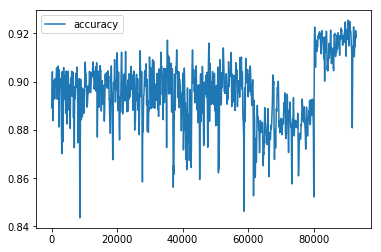

In [34]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b), sigma=50), columns=['accuracy']).plot(y='accuracy', kind='line')

In [22]:
correct_sents.double() / total_sents

tensor(0.4366, device='cuda:0', dtype=torch.float64)

In [23]:
np.array(accuracy_b).mean()

0.8886814369380468

In [35]:
target_inp = target.view(-1).to(device)
maskinp = mask.view(-1).to(device)
torch.sum(torch.sum(((target_inp == out).double() * maskinp).reshape(target.shape), dim=1) == torch.sum((maskinp).reshape(target.shape), dim=1))

tensor(0, device='cuda:0')

In [96]:
torch.sum(maskinp)

tensor(60, device='cuda:0')

In [98]:
correct_sents.double() / total_sents

tensor(0.1873, device='cuda:0', dtype=torch.float64)

In [36]:
target, out.reshape(target.shape)

(tensor([[  5240,   1696,   1755,  67827,   3233,     88,  10811,    287,  10198,
           47909,     88,  21274,   3233,   2828,      1],
         [   207,   9908,     30,    902,    531,   6196,      3,   5517,     12,
           13527, 170452,     92,   4000,  55503,      1],
         [  1235,     21,   1323, 114351,     19,     66,  24080,     31,     32,
            6182,     77,   5662,   6884,    597,      1],
         [    52,      3,   1205,   1120,    870,   7038, 137391,      4,    329,
              15,  15977,    262,      4,     66,      1]]),
 tensor([[  5240,   1696,   1755,  67827,   3233,    287,  10811,    287,  10198,
           47909,     88,  21274,   3233,   2828,      1],
         [   207,   9908,     30,    902,    531,   6196,      3,   5517,     12,
           13527, 119878,     92,   4000,  55503,      1],
         [  1235,     21,   1323,  58961,     19,     66,  24080,     31,     32,
            6182,     77,   5662,   6884,    597,      1],
         [ 

In [39]:
for_dict = dict()
for i in rev_dict.keys():
    for_dict[rev_dict[i]] = i

In [51]:
print([for_dict[i.data.item()] - 1 for i in target[4]])
print([for_dict[i.data.item()] - 1 for i in out.cpu().reshape(target.shape)[4]])

IndexError: index 4 is out of bounds for dimension 0 with size 4

In [42]:
for_dict[88], for_dict[287]

(2942, 8476)

In [53]:
target * (target != out.cpu().reshape(target.shape)) * mask

tensor([[     0,      0,      0,      0,      0,     88,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [     0,      0,      0,      0,      0,      0,      0,      0,      0,
              0, 170452,      0,      0,      0,      0],
        [     0,      0,      0, 114351,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [     0,      0,      0,      0,    870,      0, 137391,      0,      0,
              0,      0,      0,      0,      0,      0]])

In [41]:
out.cpu().reshape(target.shape) * (target != out.cpu().reshape(target.shape))

tensor([[     0,      0,      0,      0,      0,    287,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [     0,      0,      0,      0,      0,      0,      0,      0,      0,
              0, 119878,      0,      0,      0,      0],
        [     0,      0,      0,  58961,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [     0,      0,      0,      0,   5086,      0, 130159,      0,      0,
              0,      0,      0,      0,      0,      0]])

In [105]:
for_dict[13527], for_dict[12014]

(23860, 63561)

In [83]:
torch.sum(mask), mask.shape

(tensor(60), torch.Size([4, 15]))

In [77]:
cou_mistakes = cou_total - cou_mistakes

In [78]:
cou_first_word_mistakes, cou_mistakes, cou_total

(tensor(1314713., device='cuda:0', dtype=torch.float64),
 tensor(13212885., device='cuda:0', dtype=torch.float64),
 tensor(53984125, device='cuda:0'))

In [31]:
new_batch_size = 16
for file_idx in range(fileind):
    my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
    for is_test, x1, y1 in my_data_from_file:
        if is_test == 0:
            continue
        for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
            x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
            target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
            mask = (target != 0)
            batch_n += 1
            tt = time.time()
            x_inp = pad_sequence(x, batch_first=True).long().to(device)
            target_inp = target.view(-1).to(device)
            maskinp = mask.view(-1).to(device)
            out = model.predict(x_inp)
            accuracy = torch.sum((target_inp == out).double() * maskinp) / torch.sum(maskinp)
            del x_inp
            del target_inp
            del maskinp
            break
            modt += time.time() - tt
            if (batch_n % (100 * 2048 // new_batch_size) == 0):
                print('Batch: [{}]\t Accuracy: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(accuracy_b[-(100 * 2048 // new_batch_size)]).mean(), time.time() - tbegin, modt), file=file_output_b_n)
        break
    del my_data_from_file
    break

In [37]:
for_dict = dict()
for i in rev_dict.keys():
    for_dict[rev_dict[i]] = i

In [40]:
x[2]

tensor([[ 0,  0,  0,  0,  0,  0, 18, 15, 17, 15, 11, 15, 20, 18, 19, 33],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15, 33],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  5, 17,  1,  3,  9,  9, 33],
        [34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]],
       dtype=torch.uint8)

In [72]:
for_dict[4003]

25701

In [71]:
for_dict[4475]

216

In [36]:
out.reshape(target.shape)

tensor([[  235,  1906,     1,   196,   196,     3,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [ 6558, 14297,     4,  4487,     6,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [17047,    17,  2861,     1,     2,     3,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [ 4003,    17,  2861,   116,   780,  5055,   166,     1,     1,     1,
             1,     1,     1,     1,     1],
        [ 2723,   376, 28729,  4717,     1,     3,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [  425,   701,     2,   693,     1,     3,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [10096,     1,     3,   196,   196,     3,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [ 4003,    17,  4095,     1,     2,     3,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        

In [73]:
target.shape

torch.Size([16, 15])

In [35]:
target

tensor([[   235,   1906,      1,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [  6558,  14297,      4,   4487,      6,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [ 19678,     17,   2861,      1,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [  4475,     17,   2861,    116,    780,   5055,    166,      1,      0,
              0,      0,      0,      0,      0,      0],
        [  2723,    376,  13036,   4717,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [   425,    701,      2,    693,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [ 31389,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [  4475,     17,   

In [24]:
np.array(accuracy_b).mean()

0.7550915855705582

In [23]:
np.array(accuracy_b).mean()

0.750151612271121

In [20]:
np.array(accuracy_b).mean()

0.7417894242224554

1 эпоха 0.7417894242224554

In [ ]:
def eval_loss(model):
    test_losses_data_1 = []
    model.eval()
    #model.to(device)
    train_losses = []
    test_losses = []
    last_train_loss = 0
    last_test_loss = 0
    batch_n = 0
    for file_idx in range(fileind):
        my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
        for is_test, x1, y1 in my_data_from_file:
            for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
                x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
                mask = (target != 0)
                batch_n += 1
                tt = time.time()
                opt.zero_grad()
                x_inp = pad_sequence(x, batch_first=True).long().to(device)
                target_inp = target.view(-1).to(device)
                maskinp = mask.view(-1).to(device)
                loss = model(x_inp, target_inp, maskinp) / len(y)
    return test_losses_data_1

In [ ]:
def m_forward(model, x):
    rest = model.predict(x)
    #res = torch.reshape(rest, (5, 8))
    #_, ind = torch.topk(res, 1, dim=1)
    return rest


In [ ]:
def get_example(model, my_data_from_file):
    model.eval()
    last_train_loss = 0
    last_test_loss = 0
    #batch_n = 0
    #modt = 0
    #tbegin = time.time()
    new_batch_size = 256
    for file_idx in range(fileind):
        print(file_idx)
        for is_test, x1, y1 in my_data_from_file:
            if is_test == 0:
                continue
            for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
                x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                tt = time.time()
                #batch_n += 1
                target = pad_sequence(y, batch_first=True)
                #mask = (target != 0)
                X = pad_sequence(x, batch_first=True).long().to(device)
                ret = m_forward(model, X)
                for i in range()
                #loss = model(pad_sequence(x, batch_first=True).long().to(device), target.view(-1, 1).to(device), dset.get_neg(5, target.shape[0] * target.shape[1]).to(device), mask.view(-1).to(device)) / len(y)
                #test_losses_data_1.append(loss.data.item())
                #test_losses.append(loss.data.item())
                #modt += time.time() - tt
                #del my_data_from_file
                return X[:5], y[:5], ret


In [ ]:
del my_data_from_file

In [ ]:
my_data_from_file = torch.load(f"source_files/data_1024_ixy_0")

In [ ]:
a, b, c = get_example(model, my_data_from_file)

In [ ]:
c.reshape(5, 8)

In [ ]:
[[rev_dict[i.data.item()] for i in j] for j in b]

In [ ]:
rev_dict[0]

In [ ]:
b

In [ ]:
_, ind = torch.topk(c, 10, dim=2)

In [ ]:
c[0][1][2]

In [ ]:
c[0][1][444400]

In [ ]:
print(ind)

In [ ]:
fileind = 12

In [ ]:
tld = eval_loss(model)


In [ ]:
train_l_np = gaussian_filter1d(np.array(tld), sigma=50)
pd.DataFrame(train_l_np, columns=['loss']).plot(y='loss', kind='line')

In [ ]:
np.array(tld).mean()

In [ ]:
torch.save((train_losses_data, test_losses_data), "losses_vector")

In [ ]:
torch.save(model, "model_epoch_2.pt")

In [ ]:
dtestloss_epoch_1 = pd.DataFrame(epoch_1_losses, columns=['loss'])


In [ ]:
(len(train_losses_data) - len(train_losses)) / 12

In [ ]:
(len(test_losses_data) - len(test_losses)) / 12

In [ ]:
26138.0 + 2907

In [ ]:
batch_n

In [32]:
import pandas as pd

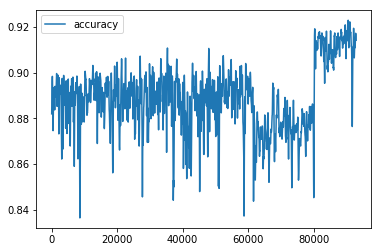

In [26]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b), sigma=50), columns=['accuracy']).plot(y='accuracy', kind='line')

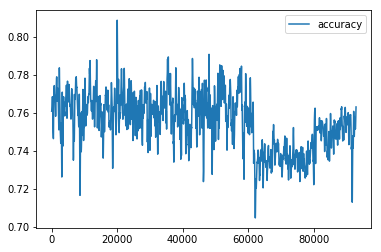

In [27]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b), sigma=50), columns=['accuracy']).plot(y='accuracy', kind='line')

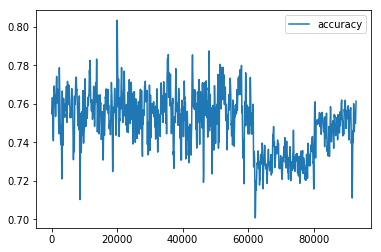

In [26]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b), sigma=50), columns=['accuracy']).plot(y='accuracy', kind='line')

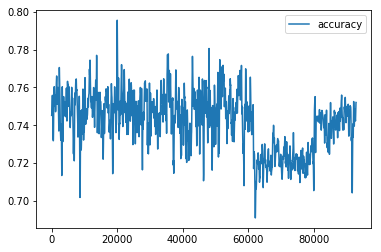

In [25]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b), sigma=50), columns=['accuracy']).plot(y='accuracy', kind='line')

Ниже изображена сглаженная точность по батчам, видные резкие перепады совпадают со сменой тематики датасета

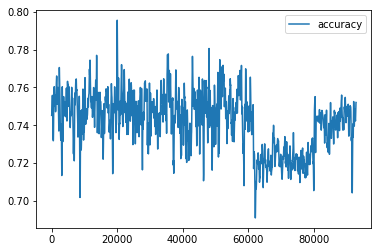


In [33]:
from scipy.ndimage.filters import gaussian_filter1d


In [ ]:
def get_epoch_loss_train(epoch):
    #epoch_1_losses = []
    #tmp = []
    #for i in range(epoch * 26138, epoch * 26138 + 26138):
    #    epoch_1_losses.append(np.array(tmp).mean())
    #    if (len(tmp) >= 1000):
    #        tmp = tmp[1:]
    #    tmp.append(train_losses_data[i])
    train_l_np = gaussian_filter1d(np.array(train_losses_data[epoch * 26138 : epoch * 26138 + 26138]), sigma=50)
    #epoch_1_losses.append(np.array(tmp).mean())
    #tmp = []
    dtestloss_epoch_1 = pd.DataFrame(train_l_np, columns=['loss'])
    return dtestloss_epoch_1

In [ ]:
def get_epoch_loss_test(epoch):
    '''epoch_1_losses = []
    tmp = []
    for i in range(epoch * 2907, epoch * 2907 + 2907):
        if (len(tmp) == 1000):
            epoch_1_losses.append(np.array(tmp).mean())
            tmp = []
        tmp.append(test_losses_data[i])
    epoch_1_losses.append(np.array(tmp).mean())
    tmp = []
    dtestloss_epoch_1 = pd.DataFrame(epoch_1_losses, columns=['loss'])'''
    test_l_np = gaussian_filter1d(np.array(test_losses_data[epoch * 2907 : epoch * 2907 + 2907]), sigma=50)
    #epoch_1_losses.append(np.array(tmp).mean())
    #tmp = []
    dtestloss_epoch_1 = pd.DataFrame(test_l_np, columns=['loss'])
    return dtestloss_epoch_1

In [ ]:
for i in range(10):
    get_epoch_loss_train(i).plot(y='loss', kind='line')

In [ ]:
for i in range(10):
    get_epoch_loss_test(i).plot(y='loss', kind='line')

Как видно выше, значительные скачки в качестве работы модели совпадают с двумя изменениями базы данных

In [ ]:
3.8 / (3.8 + 1.1 + 0.9) * 255

epoch [1 / 5]	 Test loss: 0.5099887331205446, Train loss: 0.5170078234841905, Time: 11539.199964046478


epoch [2 / 5]	 Test loss: 0.33134568085119326, Train loss: 0.32768780448848756, Time: 7863.206111431122


epoch [3 / 20]	 Test loss: 0.2708103725174714, Train loss: 0.2646242863751537, Time: 8577.930572748184


29045 батчей всего

In [ ]:
2355

In [ ]:
batch_n

In [ ]:
class Word2Vec(nn.Module):
    def __init__(self, vec_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.word_embed = nn.Embedding(vocab_size, vec_size, sparse=True)
        self.cont_embed = nn.Embedding(vocab_size, vec_size, sparse=True)

    def forward(self, X, Y_p, Y_n):
        embed_w = self.word_embed(X)
        embed_cp = self.cont_embed(Y_p)
        embed_cn = self.cont_embed(Y_n)

        neg_sim = torch.bmm(embed_cn, embed_w.unsqueeze(2))
        neg_sim = neg_sim.squeeze(2)
        neg_sim = torch.clamp(neg_sim, max=10, min=-10)
        neg_loss = -torch.sum(F.logsigmoid(-neg_sim), dim=1)

        pos_sim = torch.sum(torch.mul(embed_cp, embed_w), dim=1)
        pos_sim = torch.clamp(pos_sim, min=-10, max=10)
        pos_loss = -F.logsigmoid(pos_sim)

        return pos_loss + neg_loss

In [ ]:
print(torch.__version__)
import pickle


In [ ]:
word2vecdataset = MyWord2VecDatasetFromMongo([collection_gardening, collection_opposition, collection_relig], 3, 5, need_neg=False)

In [ ]:
for i in word2vecdataset:
    print(i)
    break

In [ ]:
word2vecdataload = MyBatcher([word2vecdataset], 16384 * 2, 0, 22)

In [ ]:
n_epochs_w2v = 20

In [ ]:
torch.cuda.empty_cache()

In [ ]:
w2vmodel = Word2Vec(vec_size, vocab_word_size).to(device)

In [ ]:
optimw2vec = optim.SparseAdam(w2vmodel.parameters(), lr=1e-3)
#sched = optim.lr_scheduler.CosineAnnealingLR(optimw2vec, len(self.dataloader))


In [ ]:
for epoch in range(n_epochs_w2v):
    train_loss = []
    n_batch = 0
    t = time.time()
    dset.shuffle_neg()
    for _, x, y in word2vecdataload:
        neg = torch.tensor(dset.get_neg(5, len(y))).to(device)
        n_batch += 1
        if (n_batch % 1000 == 0):
            print(f'epoch: [{epoch} / {n_epochs_w2v}], batch: [{n_batch}], loss: {np.array(train_loss).mean()}, time: {time.time() - t}, kerrs: {kerrs}')
            train_loss = []
        #sched.step()
        optimw2vec.zero_grad()
        xdev = torch.tensor(x).to(device)
        ydev = torch.tensor(y).to(device)
        loss = w2vmodel(xdev, ydev, neg)
        loss_s = loss.mean()
        loss_s.backward()
        train_loss.append(loss_s.data.item())
        optimw2vec.step()
    torch.save(w2vmodel, f"model_{epoch // 2}")

In [ ]:
torchmass = []

In [ ]:

cou_sents = 0
kerrs = 0
knerrs = 0
t = time.time()
posts = collection_relig.find({}, {'_id': 1, 'y_sentences': 1}, no_cursor_timeout=True)
for elem in posts:
    try:
        sents = elem['y_sentences']
    except KeyError:
        kerrs += 1
        continue
    knerrs += 1
    for sent in sents:
        cou_sents += 1
        torchmass.append(sent[:-1])
    if (cou_sents % 1000 == 0):
        print(cou_sents, knerrs, kerrs, time.time() - t)

In [ ]:
file = open("data_r_string_format", "wt")

In [ ]:
file2 = open("data_sum_string_format", "wt")

In [ ]:
suml = 0
maxw = 0
scou = 0
print(len(torchmass))

In [ ]:
maxl = 0
for i in torchmass:
    maxl = max(maxl, len(i))

In [ ]:
maxl

In [ ]:
t = time.time()
for i in torchmass:
    suml += len(i)
    scou += 1
    if (scou % 1000 == 0):
        print(scou, time.time() - t)
    for j in i:
        print(j, end=' ', file=file2)
    print(file=file)
    maxw = max(maxw, max(i))

In [ ]:
print(maxw)

In [ ]:
for i in torchmass:
    print(*i, file=file)

In [ ]:
cou_sents = 0
kerrs = 0
knerrs = 0
t = time.time()
posts = collection_opposition.find({}, {'_id': 1, 'y_sentences': 1}, no_cursor_timeout=True)
for elem in posts:
    try:
        sents = elem['y_sentences']
    except KeyError:
        kerrs += 1
        continue
    knerrs += 1
    for sent in sents:
        cou_sents += 1
        torchmass.append(sent[:-1])
    if (cou_sents % 1000 == 0):
        print(cou_sents, knerrs, kerrs, time.time() - t)

In [ ]:
torch.save(torchmass, "data_ro.out")
del torchmass
torchmass = []

In [ ]:
cou_sents = 0
kerrs = 0
knerrs = 0
t = time.time()
posts = collection_gardening.find({}, {'_id': 1, 'y_sentences': 1}, no_cursor_timeout=True)
for elem in posts:
    try:
        sents = elem['y_sentences']
    except KeyError:
        kerrs += 1
        continue
    knerrs += 1
    for sent in sents:
        cou_sents += 1
        torchmass.append(sent[:-1])
    if (cou_sents % 1000 == 0):
        print(cou_sents, knerrs, kerrs, time.time() - t)

In [ ]:
!pip install gensim

In [ ]:
for i in range(len(torchmass)):
    for j in range(len(torchmass[i])):
        torchmass[i][j] = str(torchmass[i][j])

In [ ]:
from gensim.models import Word2Vec

In [ ]:
myw2v = Word2Vec(size=300, window=5, min_count=1, sg=1, hs=0, negative=5, ns_exponent=0.7, sample=1e-3)

In [ ]:
myw2v.build_vocab(torchmass)

In [ ]:
import datetime
print(datetime.datetime.now())
t = time.time()
myw2v.train(torchmass, total_examples=len(torchmass), start_alpha=5e-3, end_alpha=1e-4, epochs=5, compute_loss=True)
print(time.time() - t)
print(datetime.datetime.now())

In [ ]:
neg_samples_file = "data_files/neg_samples.out"

In [ ]:
torch.save(word2vecdataset.neg_samples, neg_samples_file)

In [ ]:
torch.save(torchmass, target_data_file)

In [ ]:
35000

In [ ]:
%%time
t = time.time()
for is_test, x, y in my_dataloader:
    if (babatch_n % 1000 == 0):
        print(babatch_n, time.time() - t)
    babatch_n += 1


In [ ]:
t2 = torch.ones((2, 3, 5))

In [ ]:
torch.bmm(t1, t2).shape, torch.bmm(t1, t2)

In [ ]:
t = torch.ones((2, 3, 4))
for i in range(2):
    for j in range(3):
        for k in range(4):
            t[i][j][k] = i + j * 2 + k * 6

In [ ]:
np.array(train_losses).mean()

In [ ]:
a = t.reshape(2, 12)
a

In [ ]:
np.array([1, 2, 3, 4]) > 2

In [ ]:
t = torch.zeros(2, 2)

In [ ]:
t[0][0] = 1
t[0][1] = 2
t[1][0] = 1000
t[1][1] = 1000

In [ ]:
aaaaa = F.softmax(t, dim = 1)

In [ ]:
aaaaa.topk(1)[1].shape

In [ ]:
aaaaa

In [ ]:
errors, words

In [ ]:
train_losses

In [ ]:
ncou = 0

In [ ]:
for a in word_cou.keys():
    b = word_cou[a]
    if (b > 5):
        ncou += 1

In [ ]:
ncou

In [ ]:
t = torch.zeros(64)
t2 = torch.zeros(64)

In [ ]:
t * t2

In [ ]:
1236-ord('а')

In [ ]:
chr(164)